In [22]:
import sys
sys.path.insert(0, "/Users/labo_dupe/Documents/GitHub/PyImage/utils/")
import numpy as np
from PIL import Image
import os
from tifffile import imread
import matplotlib.pyplot as plt
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from plot_utils import singleplot, plotXY, doubleplot
from GaussFit import StripFitTime, Linescan, ShiftFit,  ReadFit,FinalShiftFit
from HoughLine import show_hough_linetransform, show_ransac_points_line, show_plot, Correlation_plot,show_intensity_plot, Peak_Data
from bokeh.models import Label
from bokeh.io import export_png
from bokeh.plotting import figure, show, output_notebook
from IPython.display import clear_output
from bokeh.models import Range1d
import csv
from GaussFit import MakePath

In [23]:
targetdir = 'F:/Ozge/20190417_colorcorrected_croped/box_10um_LS_20px_40um'

Membraneimage = 'F:/Ozge/20190417_colorcorrected_croped/box_10um_LS_20px_40um/Ch1LineScan_C2-20190417_1x16_1TrackID1.tif'

Actinimage = 'F:/Ozge/20190417_colorcorrected_croped/box_10um_LS_20px_40um/Ch2LineScan_C2-20190417_1x16_1TrackID1.tif'



#Enter time unit in seconds
Time_unit = 5
#Enter pixel to micrometer conversion
Xcalibration = 0.1032
#Enter the number of pixels to be included in the fit
Fitaround= 8


#Symmetric psf as input (micrometers)
psf = 0.17

showaftertime = 10
inisigmaguess =  psf
#Size of linescan
skip = 50
singleblock = 80 

#Number of segments
numsegments = 10
id = []
for i in range(0, numsegments):
    id.append(i)
    
MakePath(targetdir)    
save_dir = targetdir + 'ls_data_time'    
MakePath(save_dir)

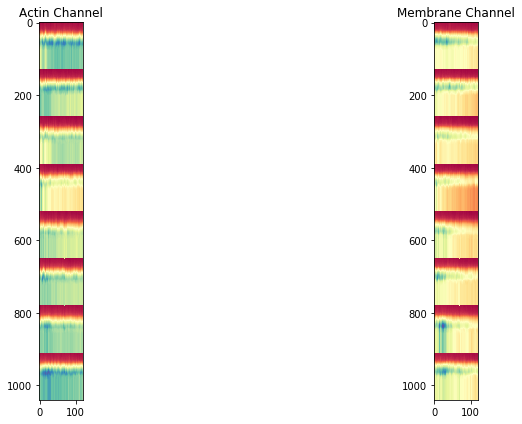

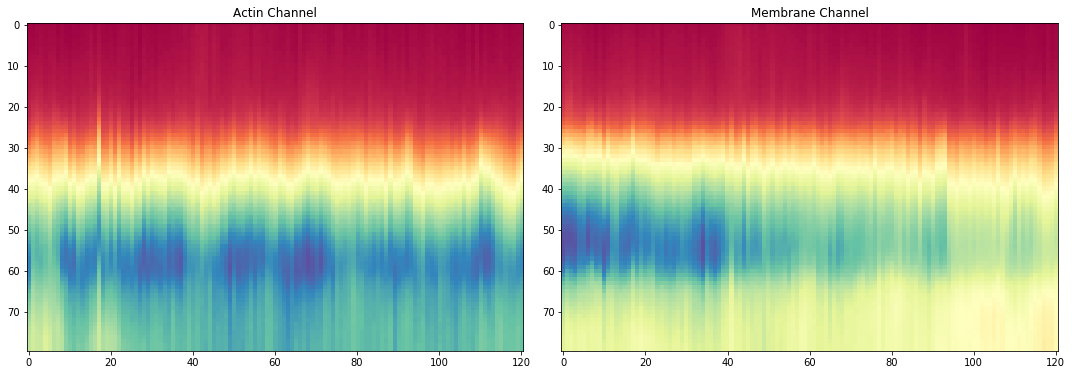

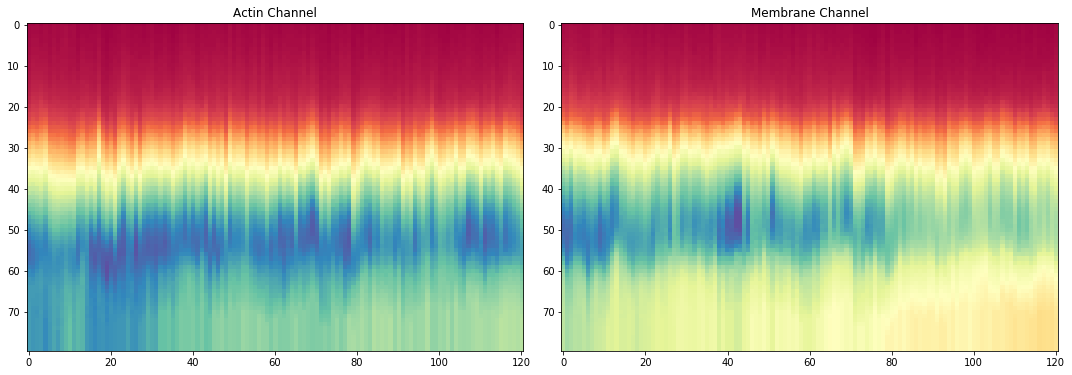

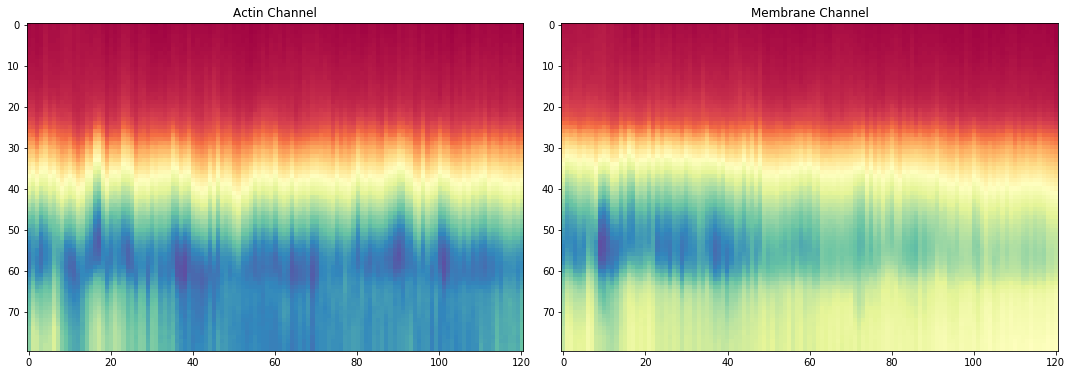

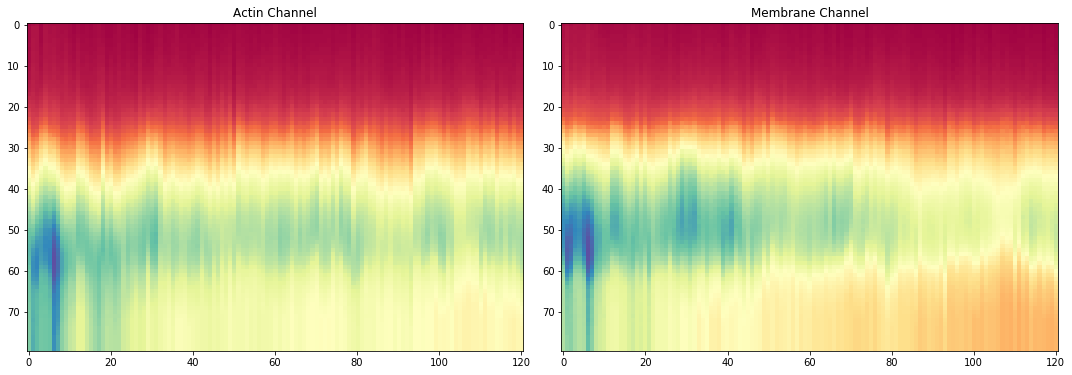

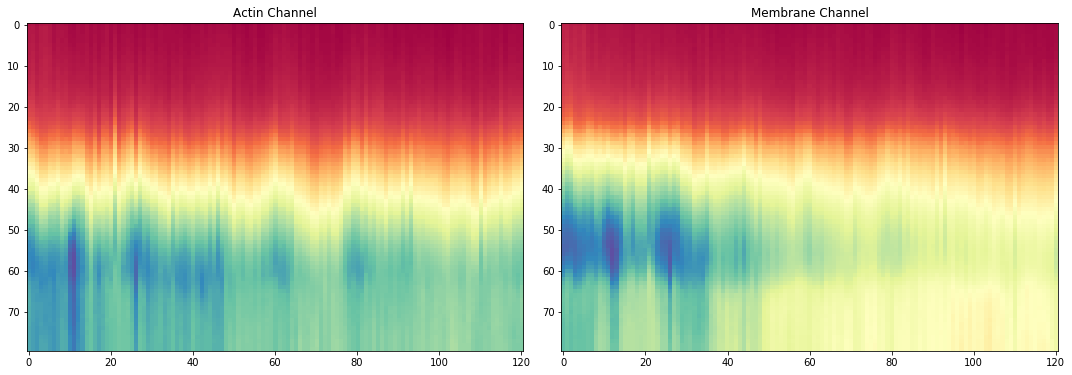

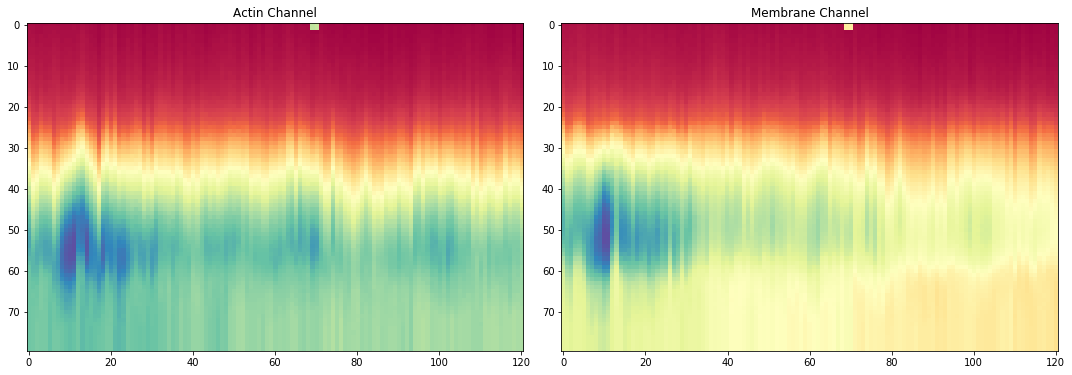

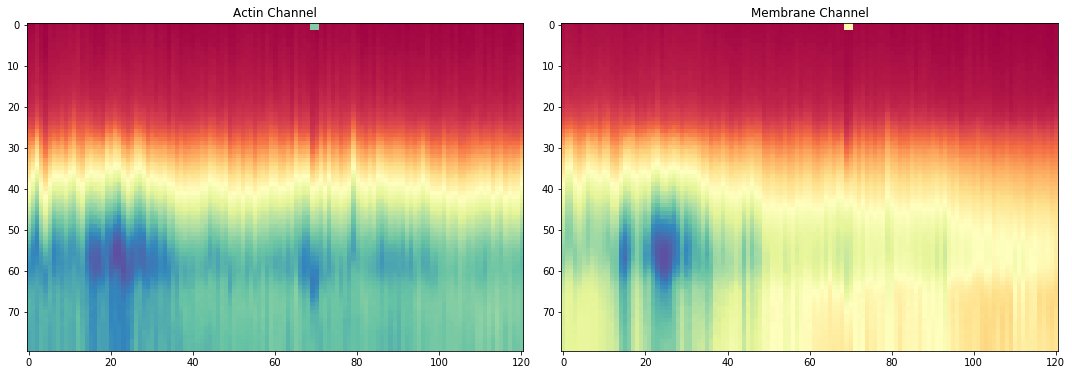

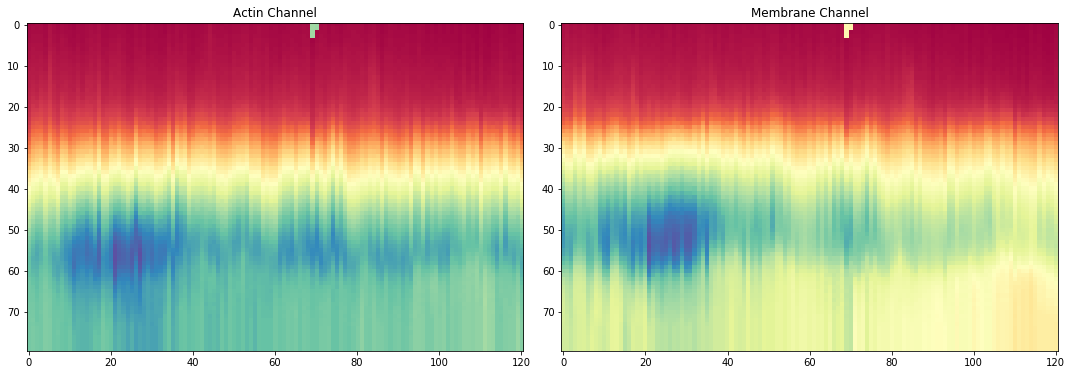

In [24]:
Actin = imread(Actinimage)
Membrane = imread(Membraneimage)
SimTime = Actin.shape[1]
doubleplot(Actin, Membrane, 'Actin Channel', 'Membrane Channel')
blockimageActin = []
blockimageMembrane = []

i = 0
while i < Actin.shape[0]:
       
   blockActin = Actin[i:i + singleblock,:]#/np.amax(Actin[i:i + singleblock,:], 0)
   blockMembrane = Membrane[i:i + singleblock,:]#/np.amax(Membrane[i:i + singleblock,:],0)
   
   blockimageActin.append(blockActin)
   blockimageMembrane.append(blockMembrane)
   doubleplot(blockActin, blockMembrane, 'Actin Channel', 'Membrane Channel')
   i = i + singleblock + skip 

halflength = int(len(blockimageActin)/2)
otherhalf = len(blockimageActin) - halflength
totallength = len(blockimageActin)

In [25]:
%%time
#Fit all blocks
global Thickness, Intensity, PeakActin, DataActin, PeakMembrane, DataMembrane, Time, ID, MegaBlockActin, MegaBlockMembrane, BlockAverageActin, BlockAverageMembrane
global Thickness_intensity, Thickness_time
Thickness = []
Intensity = []
PeakActin = []
DataActin = []
PeakMembrane = []
DataMembrane = []
Time = []
ID = []
MegaBlockActin = []
MegaBlockMembrane = []
BlockAverageActin = []
BlockAverageMembrane = []
for t in range(0, SimTime):
  BlockActin = []
  BlockMembrane = []
  for i in range(0, totallength):
    
     
    
     print('block id', i+1, 'time averaged', t) 
     currentid = i+1
     ID.append(i + 1)
     Actin = blockimageActin[i]
     Membrane = blockimageMembrane[i]
     X = []
     I = []
     membraneimageX = []
     membraneimageI = []
     strip = Actin[:Actin.shape[0],t]
     membraneimagestrip = Membrane[:Membrane.shape[0],t]
     for j in range(strip.shape[0]):
           X.append(j * Xcalibration)
           I.append(strip[j])
        
        
     X = np.asarray(X)
     I = np.asarray(I)
     for j in range(membraneimagestrip.shape[0]):    
           membraneimageX.append(j * Xcalibration)
           membraneimageI.append(membraneimagestrip[j]) 
           
     membraneimageX = np.asarray(membraneimageX)
     membraneimageI = np.asarray(membraneimageI)
     StripFitTime(X, I,membraneimageX,membraneimageI,Time_unit,Xcalibration,  Fitaround, psf, inisigmaguess, showaftertime, Thickness, Intensity, BlockActin, BlockMembrane, Time, t)
  if(len(BlockActin) > 0 and len(BlockMembrane)> 0 ):  
     ShiftFit(BlockActin, BlockMembrane,BlockAverageActin,BlockAverageMembrane, Time_unit, Xcalibration, Fitaround
             , psf, inisigmaguess, showaftertime,Thickness, Intensity,   Time, t) 
     clear_output(wait=True)
   

 


block id 1 time averaged 120
block id 2 time averaged 120
block id 3 time averaged 120
block id 4 time averaged 120
block id 5 time averaged 120
block id 6 time averaged 120
block id 7 time averaged 120
block id 8 time averaged 120
Wall time: 15min 32s


In [26]:
print("Thickness (min)",np.min(Thickness) *1000, "nm")
print("Thickness (median)",np.median(Thickness) *1000, "nm")
print("Thickness (max)",np.max(Thickness) *1000, "nm")
Thickness_intensity = np.column_stack([Thickness, Intensity]) 
Thickness_time= np.column_stack([Thickness, Time])

master_data= []

Path(save_dir).mkdir(exist_ok = True)

for line in Thickness_time:
    master_data.append(line)
file =    open(save_dir + "/" + ( "Time" + os.path.basename(Actinimage))  +".csv", "w")
writer = csv.writer(file)
writer.writerows(master_data) 
file.close()


Thickness (min) 139.6644265879181 nm
Thickness (median) 805.903575763623 nm
Thickness (max) 1364.219488817868 nm


X: 130.74327741916596 Y:  0.81272688698464
Standard deviation: 26.12421298756749
X: 124.12197584632156 Y:  0.7289504528127667
Standard deviation: 26.12421298756749


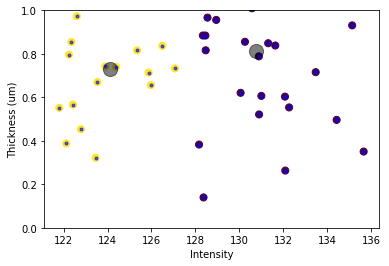

X: 89.66666666666667 Y:  0.8023484983216459
Standard deviation: 1844.4394301933341
X: 34.000000000000014 Y:  0.7649480109412754
Standard deviation: 1844.4394301933341


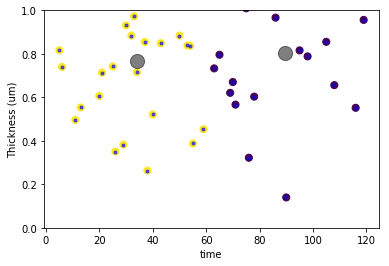

In [27]:
num_clusters = 2
show_intensity_plot(Thickness_intensity,save_dir,os.path.basename(Actinimage), ymin = 0, ymax = 1, num_clusters = num_clusters  )
    
show_intensity_plot(Thickness_time,save_dir,os.path.basename(Actinimage), ymin = 0, ymax = 1, num_clusters = num_clusters, title = 'time' )



/Users/labo_dupe/Documents/GitHub/PyImage/utils\GaussFit.py:612: RuntimeWarning: invalid value encountered in double_scalars
  m_left = (self.i[self.left_index_right] - self.i[self.left_index_left]) /  (self.x[self.left_index_right] - self.x[self.left_index_left])
/Users/labo_dupe/Documents/GitHub/PyImage/utils\GaussFit.py:628: RuntimeWarning: invalid value encountered in double_scalars
  m_right = (self.i[self.right_index_right] - self.i[self.right_index_left]) / (self.x[self.right_index_right] - self.x[self.right_index_left])


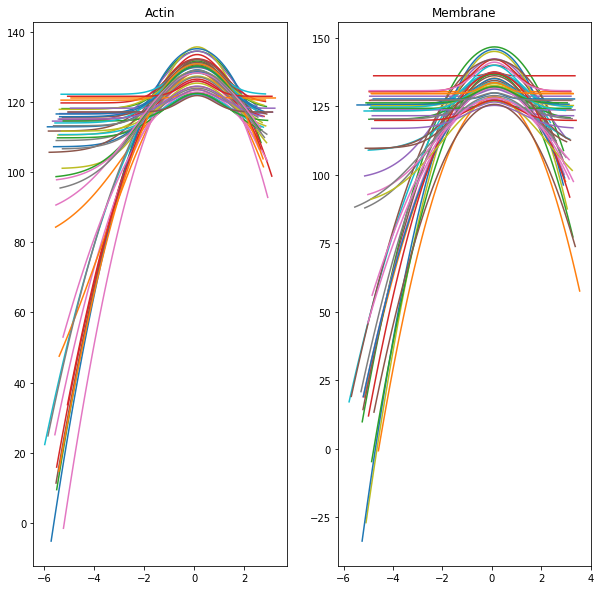

Membrane Fit: (Amp, Sigma, PeakPos, C) [3.58964076e+01 1.11061844e+00 8.84007570e-02 1.20650001e+02]
Actin Fit: [6.15475929e+01 1.41956037e+00 9.41059718e-02 1.10731426e+02]


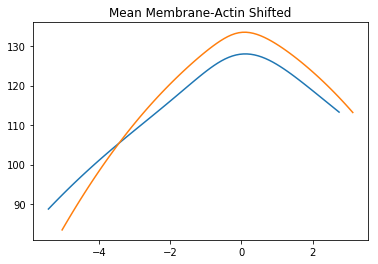

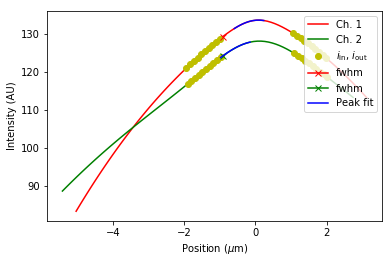

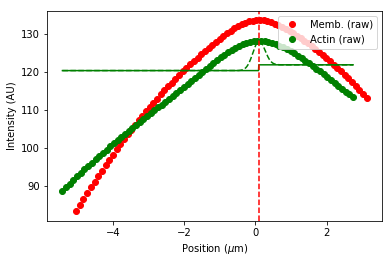

Thickness (nm), center cortex , cortical actin intensity (from fit) 5.697590843512317 0.09124955241310452 640.1657530892377


In [28]:

FinalThickness = []
FinalIntensity = []
FinalTime = []
FinalShiftFit(BlockAverageActin, BlockAverageMembrane, Time_unit, Xcalibration, Fitaround
             , psf, inisigmaguess, showaftertime,FinalThickness, FinalIntensity,   FinalTime, 0)




In [29]:
Final_master_data= []
Final_Thickness = np.column_stack([FinalThickness, os.path.basename(Actinimage)]) 
for line in Final_Thickness:
    Final_master_data.append(line)
Final_file =    open(save_dir + "/" + ( "Master" + os.path.basename(Actinimage))  +".csv", "w")
writer = csv.writer(Final_file)
writer.writerows(Final_master_data) 
Final_file.close()

In [30]:

hist, edges = np.histogram((Thickness), density=False, bins='auto')
p = figure(title="Estimated Cortex Thickness = " + str('%.5f'%np.abs(edges[np.argmax(hist)] * 1000)) + 'nm', y_axis_label='Counts',x_axis_label='Thickness(um)')
listedges = edges.tolist()
listhist = hist.tolist()
output_notebook()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
    fill_color="#036564", line_color="#033649")
for  i in range(0,len(listhist)):
  if listhist[i] > 0:
   mytext = Label(x=listedges[i], y=listhist[i], text=str('%.4f'%listedges[i]))
   p.add_layout(mytext)
show(p)

export_png(p, filename=save_dir +  "/" +  'Bokeh_Histogram' + os.path.basename(Actinimage) + '.png')
    

Loading BokehJS ...

'F:\\Ozge\\20190417_colorcorrected_croped\\box_10um_LS_20px_40umls_data_time\\Bokeh_HistogramCh2LineScan_C2-20190417_1x16_1TrackID1.tif.png'